In [228]:
# Импортируем нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split # класс разбиения на данные для обучения и для проверки
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
# импортируем функции
from functions import generate_random_array, plot_true_vs_predicted,  Functions, Generate_data

In [229]:
# Исходные данные
# создаем объект класса Functions 
main_function = Functions()


# определяем количетсво строк для обучения
main_function.n_samples = 27

# пределы варьирования признаков
main_function.limits = (-10, 10)

# определяем вид функции
main_function.set_function(main_function.trigonometric)

# признаки переопределим с помощью ПФЭ
data_generator = Generate_data(main_function.n_samples, main_function.n_features, main_function.limits[0], 
                               main_function.limits[1], seed = main_function.random_seed)
main_function.features = data_generator.generate_latin_hypercube()

main_function.target = main_function.function(*main_function.features.T)
main_function.n_samples = data_generator.n 

In [230]:
# Генерация пула кандидатов (случайные точки в допустимом диапазоне)
rng = np.random.default_rng(seed=12345)
X_pool = rng.uniform(low=main_function.limits[0], high=main_function.limits[1], size=(100000, main_function.n_features))
y_pool = main_function.function(*X_pool.T)

In [231]:
# Попробуем определить точку, которую желательно добавить в массив для обучения
# Обучаем ансамбль из N моделей
n_models = 10
predictions = []

for i in range(n_models):
    model = XGBRegressor(
                    n_estimators=1000,
                    max_depth=3,
                    learning_rate=0.1,
                    reg_alpha=0.5,
                    reg_lambda=0.5,
                    subsample=0.8,
                    random_state=1488+i,
                    verbosity=0
                    )
    model.fit(main_function.features, main_function.target)
    pred = model.predict(X_pool)
    predictions.append(pred)

# Считаем дисперсию предсказаний по ансамблю
predictions = np.array(predictions)  # (n_models, n_pool)
# Среднеквадратичное отклонение
uncertainty = predictions.std(axis=0)  # (n_pool,)
# Расстояние до ближайшей известной точки
distances = cdist(X_pool, main_function.features).min(axis=1)
# Нормализуем оба показателя
unc_norm = uncertainty / (uncertainty.max() + 1e-9)
dist_norm = distances / (distances.max() + 1e-9)
# Считаем обобщенный показатель
score = unc_norm * dist_norm



# Выбираем точку с максимальной неопределённостью
best_idx = np.argmax(score)
features_to_add = X_pool[best_idx]
# Определяем значение целевой переменной при данных знаениях признаков
target_to_add = main_function.function(*features_to_add.T)


print(f'Следующая точка для замера - точка # {best_idx}')
print (f'Ее неопределенность равна: {uncertainty[best_idx]:.5f}')
print (f'Ее расстояние до ближайшей исвестной точки:  {distances[best_idx]:.5f}')
print (f'Ее обобщенный показатель: {score[best_idx]:.5f}')
print (f'Необходимо добавить в массив признаков следующие данные: {features_to_add}')
print (f'Значение целевой функции для данной точки будет: {target_to_add}')
print("Макс. неопределённость:", uncertainty.max())
print("Средняя неопределённость:", uncertainty.mean())
print("Медиана:", np.median(uncertainty))
print("Количество точек с uncertainty > 90%-квантиля:", np.sum(uncertainty > np.percentile(uncertainty, 90)))

Следующая точка для замера - точка # 71471
Ее неопределенность равна: 0.12628
Ее расстояние до ближайшей исвестной точки:  8.02866
Ее обобщенный показатель: 0.80113
Необходимо добавить в массив признаков следующие данные: [ 1.3815602  -9.87128691 -9.59765051]
Значение целевой функции для данной точки будет: -0.4800297730337493
Макс. неопределённость: 0.13569477
Средняя неопределённость: 0.056633644
Медиана: 0.055904895
Количество точек с uncertainty > 90%-квантиля: 9999


In [232]:
j = len(main_function.target)

In [233]:
while j <= 200:
    #Добавляем в признаки
    main_function.features = np.vstack([main_function.features,features_to_add.reshape(1, -1)])

    #Добавляем в целевую переменную
    main_function.target = np.append(main_function.target, target_to_add)

    n_models = 10
    predictions = []
    
    for i in range(n_models):
        model = XGBRegressor(
                        n_estimators=1000,
                        max_depth=3,
                        learning_rate=0.1,
                        reg_alpha=0.5,
                        reg_lambda=0.5,
                        subsample=0.8,
                        random_state=1488+i,
                        verbosity=0
                        )
        model.fit(main_function.features, main_function.target)
        pred = model.predict(X_pool)
        predictions.append(pred)
    
    # Считаем дисперсию предсказаний по ансамблю
    predictions = np.array(predictions)  # (n_models, n_pool)
    # Среднеквадратичное отклонение
    uncertainty = predictions.std(axis=0)  # (n_pool,)
    # Расстояние до ближайшей известной точки
    distances = cdist(X_pool, main_function.features).min(axis=1)
    # Нормализуем оба показателя
    unc_norm = uncertainty / (uncertainty.max() + 1e-9)
    dist_norm = distances / (distances.max() + 1e-9)
    # Считаем обобщенный показатель
    score = unc_norm * dist_norm
    
    # Выбираем точку с максимальной неопределённостью
    best_idx = np.argmax(score)
    features_to_add = X_pool[best_idx]
    # Определяем значение целевой переменной при данных знаениях признаков
    target_to_add = main_function.function(*features_to_add.T)
 
    
    j+=1

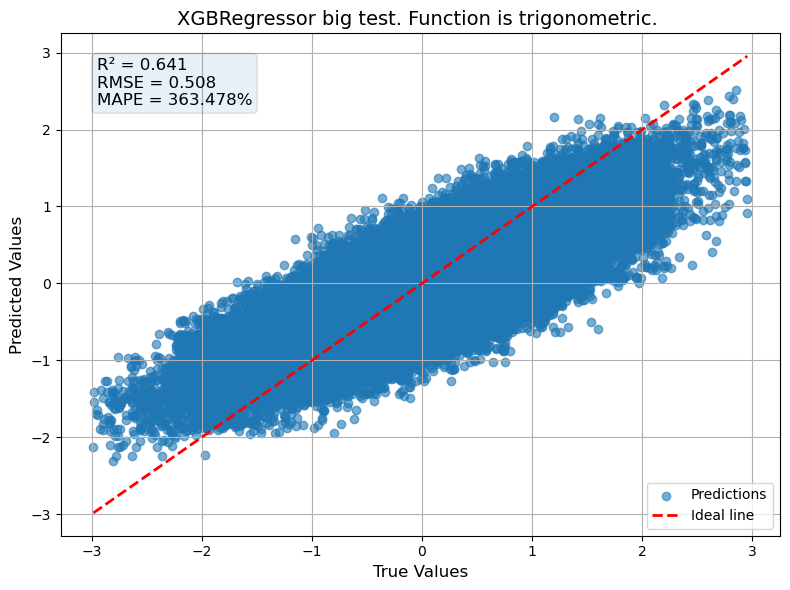

In [234]:
# посмотрим на результат
y_pred_big_test = model.predict(X_pool) 
plot_true_vs_predicted (y_pool, y_pred_big_test, title= f'XGBRegressor big test. Function is {main_function.function_name}. ')